# Initial imports

In [225]:
# Numeric and data processing
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
from pandas.api.types import CategoricalDtype

# sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion, make_union
from sklearn.metrics import make_scorer
from scipy.stats import ks_2samp
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterGrid
from sklearn.feature_selection import SelectFromModel, VarianceThreshold, chi2, SelectKBest

# plotting
import matplotlib.pyplot as plt
# %matplotlib inline
%matplotlib notebook
import scikitplot as skplt
import seaborn as sns

# lightgbm
import lightgbm as lgb

# Misc
import tqdm


In [2]:
# Global random state for reproducibility
random_state_global = 42

# Dataprep

## Reading data from csv

8. Missing Attribute Values: There are several missing values in some categorical attributes, all coded with the "unknown" label. These missing values can be treated as a possible class label or using deletion or imputation techniques. 

In [3]:
df_full = pd.read_csv('../data/bank-additional/bank-additional-full.csv', sep=';', na_values=['unknown'])
df_full.columns = df_full.columns.str.replace('.', '_')

In [4]:
df_full.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
# Is there missing values on data? YES, I forced it using a_values=['unknown'] using 
df_full.isnull().sum()

age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp_var_rate         0
cons_price_idx       0
cons_conf_idx        0
euribor3m            0
nr_employed          0
y                    0
dtype: int64

## Categorical and numeric data preprocessing

## Categorical data

Some categorical have a meaningful ordering, like education ('basic.4y' < 'basic.6y',  ...) and default ('yes' > 'no'). For these
we will use this information while creating the category data type; for the others, there is no meaningful order, and we will not specify order while creating the category data type.

In [6]:
# Frequency of categories for each categorical feature
for col in df_full.select_dtypes('O').columns:
    print('\n', col)
    print(df_full[col].value_counts(dropna=False))


 job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
NaN                330
Name: job, dtype: int64

 marital
married     24928
single      11568
divorced     4612
NaN            80
Name: marital, dtype: int64

 education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
NaN                     1731
illiterate                18
Name: education, dtype: int64

 default
no     32588
NaN     8597
yes        3
Name: default, dtype: int64

 housing
yes    21576
no     18622
NaN      990
Name: housing, dtype: int64

 loan
no     33950
yes     6248
NaN      990
Name: loan, dtype: int64

 contact
cellular     26144
telephone    15044
Name: contact, dtype: int64

 month
m

## Downcasting numeric features to reduce memory usage
(inspired on https://www.kaggle.com/gemartin/load-data-reduce-memory-usage)

In [7]:
# Dict storing datatypes of all features
dict_dtypes = {}

# Categorical features with meaningful ordering
dict_dtypes['education'] = CategoricalDtype(categories = ['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 
                                                          'professional.course', 'university.degree']
                                            , ordered=True)

dict_dtypes['default'] = CategoricalDtype(categories = ['no', 'yes'], ordered=True)
dict_dtypes['housing'] = CategoricalDtype(categories = ['no', 'yes'], ordered=True)
dict_dtypes['loan'] = CategoricalDtype(categories = ['no', 'yes'], ordered=True)
dict_dtypes['poutcome'] = CategoricalDtype(categories = ['failure', 'success'], ordered=True)# nonexistent considered as missing value
dict_dtypes['y'] = CategoricalDtype(categories = ['no', 'yes'], ordered=True)

# Polemic
dict_dtypes['day_of_week'] = CategoricalDtype(categories = ['mon', 'tue', 'wed', 'thu', 'fri'], ordered=True)
dict_dtypes['month'] = CategoricalDtype(categories = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug',
                                                     'sep', 'oct', 'nov', 'dec'], ordered=True)
# Other categorical features
for col in df_full.select_dtypes('O').columns:
    if col not in dict_dtypes.keys():
        dict_dtypes[col] = CategoricalDtype(categories = sorted(df_full[col].dropna().unique()), ordered=False)

In [8]:
# Note: pandas alerady have nullable integer datatypes, but I will not use. If a integer column have at least a missing value,
# it will be converted to float32.
for col in tqdm.tqdm(df_full.select_dtypes(np.number).columns, position=0, desc='Reducing memory usage for numeric columns'):
    _vec_min_max = df_full[col].describe()[['min','max']]
    _has_null = df_full[col].isnull().max()
    _has_float = (df_full[col] % 1 != 0).any()
    
    if _has_float or _has_null:
        dict_dtypes[col] = pd.to_numeric(_vec_min_max, downcast='float').dtype
    else:
        if _vec_min_max[0] >=0:
            dict_dtypes[col] = pd.to_numeric(_vec_min_max, downcast='unsigned').dtype
        else:
            dict_dtypes[col] = pd.to_numeric(_vec_min_max, downcast='signed').dtype

start_memory_usage = df_full.memory_usage().sum() / 1024**2
end_memory_usage = df_full.astype(dict_dtypes).memory_usage().sum() / 1024**2

print('Initial memory usage: {:.2f} MB'.format(start_memory_usage))
print('Memory usage after optimization: {:.2f} MB'.format(end_memory_usage))
print('Memory usage decreased by {:.1f}%'.format(100 * (start_memory_usage - end_memory_usage) / start_memory_usage))

Reducing memory usage for numeric columns: 100%|██████████████████████████████████████| 10/10 [00:00<00:00, 232.30it/s]


Initial memory usage: 6.60 MB
Memory usage after optimization: 1.49 MB
Memory usage decreased by 77.3%


## Applying new dtypes inplace on initial dataframe

In [9]:
df_full = df_full.astype(dict_dtypes)

# Modelling

## Train test split

In [10]:
# I used pd.get_dummies before splitting instead of including then on pipeline for simplicity
X_train, X_test, y_train, y_test = train_test_split(df_full.drop('y', axis=1), df_full['y'].cat.codes,
                                                    test_size=0.20, random_state=random_state_global)

In [11]:
num_cols = df_full.select_dtypes(np.number).columns.to_list()
cat_cols = df_full.drop(['y'], axis=1).select_dtypes('category').columns.to_list()

## KS and gini functions and sklearn scorers

In [12]:
def ks_stat(y_true, y_proba):
#     As seen on https://medium.com/@xiaowei_6531/using-ks-stat-as-a-model-evaluation-metric-in-scikit-learns-gridsearchcv-33135101601c
    return ks_2samp(y_proba[y_true==1], y_proba[y_true!=1]).statistic

ks_scorer = make_scorer(ks_stat, needs_proba=True, greater_is_better=True)

#Remove redundant calls
def ginic(actual, pred):
    actual = np.asarray(actual) #In case, someone passes Series or list
    n = len(actual)
    a_s = actual[np.argsort(pred)]
    a_c = a_s.cumsum()
    giniSum = a_c.sum() / a_s.sum() - (n + 1) / 2.0
    return giniSum / n
 
def gini_normalizedc(a, p):
    if p.ndim == 2:#Required for sklearn wrapper
        p = p[:,1] #If proba array contains proba for both 0 and 1 classes, just pick class 1
    return ginic(a, p) / ginic(a, a)

gini_scorer = make_scorer(gini_normalizedc, needs_proba=True, greater_is_better=True)

## Basic pipeline

In [13]:
# KFold for hyperparameter tuning and acessing model quality
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state_global)

In [14]:
def get_cat_codes(X, return_df=True):
    if return_df:
        return X.apply(lambda x: x.cat.codes)
    else:
        return X.apply(lambda x: x.cat.codes).values

def from_cat_to_str(X):
    return X.astype(str)
    
def f_select_dtypes(X, dtype):
    return X.select_dtypes()

select_num_transformer = FunctionTransformer(lambda x: x.select_dtypes(np.number), validate=False)
select_cat_transformer = FunctionTransformer(lambda x: x.select_dtypes('category'), validate=False)
get_cat_codes_transformer = FunctionTransformer(get_cat_codes, validate=False)
from_cat_to_str_transformer = FunctionTransformer(from_cat_to_str, validate=False)

In [ ]:
# If would like to use OneHotEncoder inside pipeline (NOT USED, just for reference!!!)
# Using sklearn pipelines
linear_model_pipeline = FeatureUnion([
    ('num_feat', make_pipeline(select_num_transformer ,StandardScaler())),
    ('cat_feat', make_pipeline(select_cat_transformer ,get_cat_features_transformer, OneHotEncoder(sparse=False, handle_unknown='ignore', categories='auto')))
     ])

# Using DataFrameMapper from sklearn_pandas (Using OneHotEncoder instead of pd.get_dummies)
# TODO: remove x0 on feature encoded on OneHotEncoder
mapper = DataFrameMapper(
    [([col], StandardScaler()) for col in num_cols] + 
    [([col], [get_cat_features_transformer, OneHotEncoder(dtype=np.int8, sparse=False, handle_unknown='ignore', categories='auto')]) for col in cat_cols]
     , input_df=True, df_out=True)
# mapper.fit_transform(df_full)

# Metrics for models

In [15]:
# Generic Pipeline
num_pipe = Pipeline(steps=[('scaler', None)])
cat_pipe = Pipeline(steps=[('cat_imputer', SimpleImputer(strategy='constant', fill_value='cat_missing')),
                           ('cat_encoder_1', None), ('cat_encoder_2', None)])

feat_pipe = ColumnTransformer(
    transformers=[
        ('cat', cat_pipe, cat_cols),
        ('num', num_pipe, num_cols)])

clf = Pipeline(steps=[('feat_pipe', feat_pipe),
                      ('classifier', None)])


In [194]:
param_grid = [
# #     Logistic regression
    {
        'feat_pipe__num__scaler': [StandardScaler()],
        'feat_pipe__cat__cat_encoder_1': [from_cat_to_str_transformer],
        'feat_pipe__cat__cat_encoder_2': [OneHotEncoder(sparse=False, categories='auto', handle_unknown='ignore', dtype=np.uint8)],
        'classifier': [LogisticRegression(random_state=random_state_global, max_iter=1000, penalty='elasticnet',
                                          solver='saga',class_weight=None, n_jobs=10)],
        'classifier__l1_ratio': [.5],
        'classifier__class_weight':['balanced']
    }
,
#     Random Forest

#      {
#          'feat_pipe__num__scaler': [None],
#          'feat_pipe__cat__cat_encoder_1': [None],
#          'feat_pipe__cat__cat_encoder_2': [OneHotEncoder(sparse=False, categories='auto', handle_unknown='ignore', dtype=np.uint8)],
#          'classifier': [RandomForestClassifier(n_jobs=10, n_estimators=500)],
#          'classifier__class_weight': ['balanced', 'balanced_subsample']
#     }
]
    
param_grid
gs = GridSearchCV(cv=kf, param_grid=param_grid, estimator=clf, n_jobs=1, scoring=ks_scorer, verbose=2, return_train_score=True)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=10, penalty='elasticnet',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False), classifier__class_weight=balanced, classifier__l1_ratio=0.5, feat_pipe__cat__cat_encoder_1=FunctionTransformer(accept_sparse=False, check_inverse=True,
                    func=<function from_cat_to_str at 0x000001F4D60C0828>,
                    inv_kw_args=None, inverse_func=None, kw_args=None,
                    pass_y='deprecated', validate=False), feat_pipe__cat__cat_encoder_2=OneHotEncoder(categorical_features=None, categories='auto', drop=None,
              dtype=<class 'numpy.uint8'>, handle_unknown='ignore',
              n_values=None, sparse=False), feat_pipe__num__scaler=StandardScaler(copy=True, with_mean=True, with_std=True) 
[CV

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.1s remaining:    0.0s


[CV] classifier=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=0.5,
                   max_iter=1000, multi_class='warn', n_jobs=10,
                   penalty='elasticnet', random_state=42, solver='saga',
                   tol=0.0001, verbose=0, warm_start=False), classifier__class_weight=balanced, classifier__l1_ratio=0.5, feat_pipe__cat__cat_encoder_1=FunctionTransformer(accept_sparse=False, check_inverse=True,
                    func=<function from_cat_to_str at 0x000001F4D60C0828>,
                    inv_kw_args=None, inverse_func=None, kw_args=None,
                    pass_y='deprecated', validate=False), feat_pipe__cat__cat_encoder_2=OneHotEncoder(categorical_features=None, categories='auto', drop=None,
              dtype=<class 'numpy.uint8'>, handle_unknown='ignore',
              n_values=None, sparse=False), feat_pipe__num__scaler=StandardScaler(copy=True, with_mean=True, with_std=True)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('feat_pipe',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('cat',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('cat_imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                

In [195]:
gs.best_params_

{'classifier': LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=0.5,
                    max_iter=1000, multi_class='warn', n_jobs=10,
                    penalty='elasticnet', random_state=42, solver='saga',
                    tol=0.0001, verbose=0, warm_start=False),
 'classifier__class_weight': 'balanced',
 'classifier__l1_ratio': 0.5,
 'feat_pipe__cat__cat_encoder_1': FunctionTransformer(accept_sparse=False, check_inverse=True,
                     func=<function from_cat_to_str at 0x000001F4D60C0828>,
                     inv_kw_args=None, inverse_func=None, kw_args=None,
                     pass_y='deprecated', validate=False),
 'feat_pipe__cat__cat_encoder_2': OneHotEncoder(categorical_features=None, categories='auto', drop=None,
               dtype=<class 'numpy.uint8'>, handle_unknown='ignore',
               n_values=None, sparse=False),
 'feat_pipe__num__scaler': StandardScaler(copy=True, 

In [196]:
gs.cv_results_

{'mean_fit_time': array([13.70339751]),
 'std_fit_time': array([2.59330428]),
 'mean_score_time': array([0.13095093]),
 'std_score_time': array([0.00145516]),
 'param_classifier': masked_array(data=[LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=0.5,
                    max_iter=1000, multi_class='warn', n_jobs=10,
                    penalty='elasticnet', random_state=42, solver='saga',
                    tol=0.0001, verbose=0, warm_start=False)],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_classifier__class_weight': masked_array(data=['balanced'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_classifier__l1_ratio': masked_array(data=[0.5],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_feat_pipe__cat__cat_encoder_1': masked_array(data=[FunctionTransformer(accept_sparse=Fals

In [197]:
ks_stat(y_train, gs.predict_proba(X_train)[:,1])

0.7628978412864098

In [198]:
ks_stat(y_test, gs.predict_proba(X_test)[:,1])

0.7528909443851732

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer

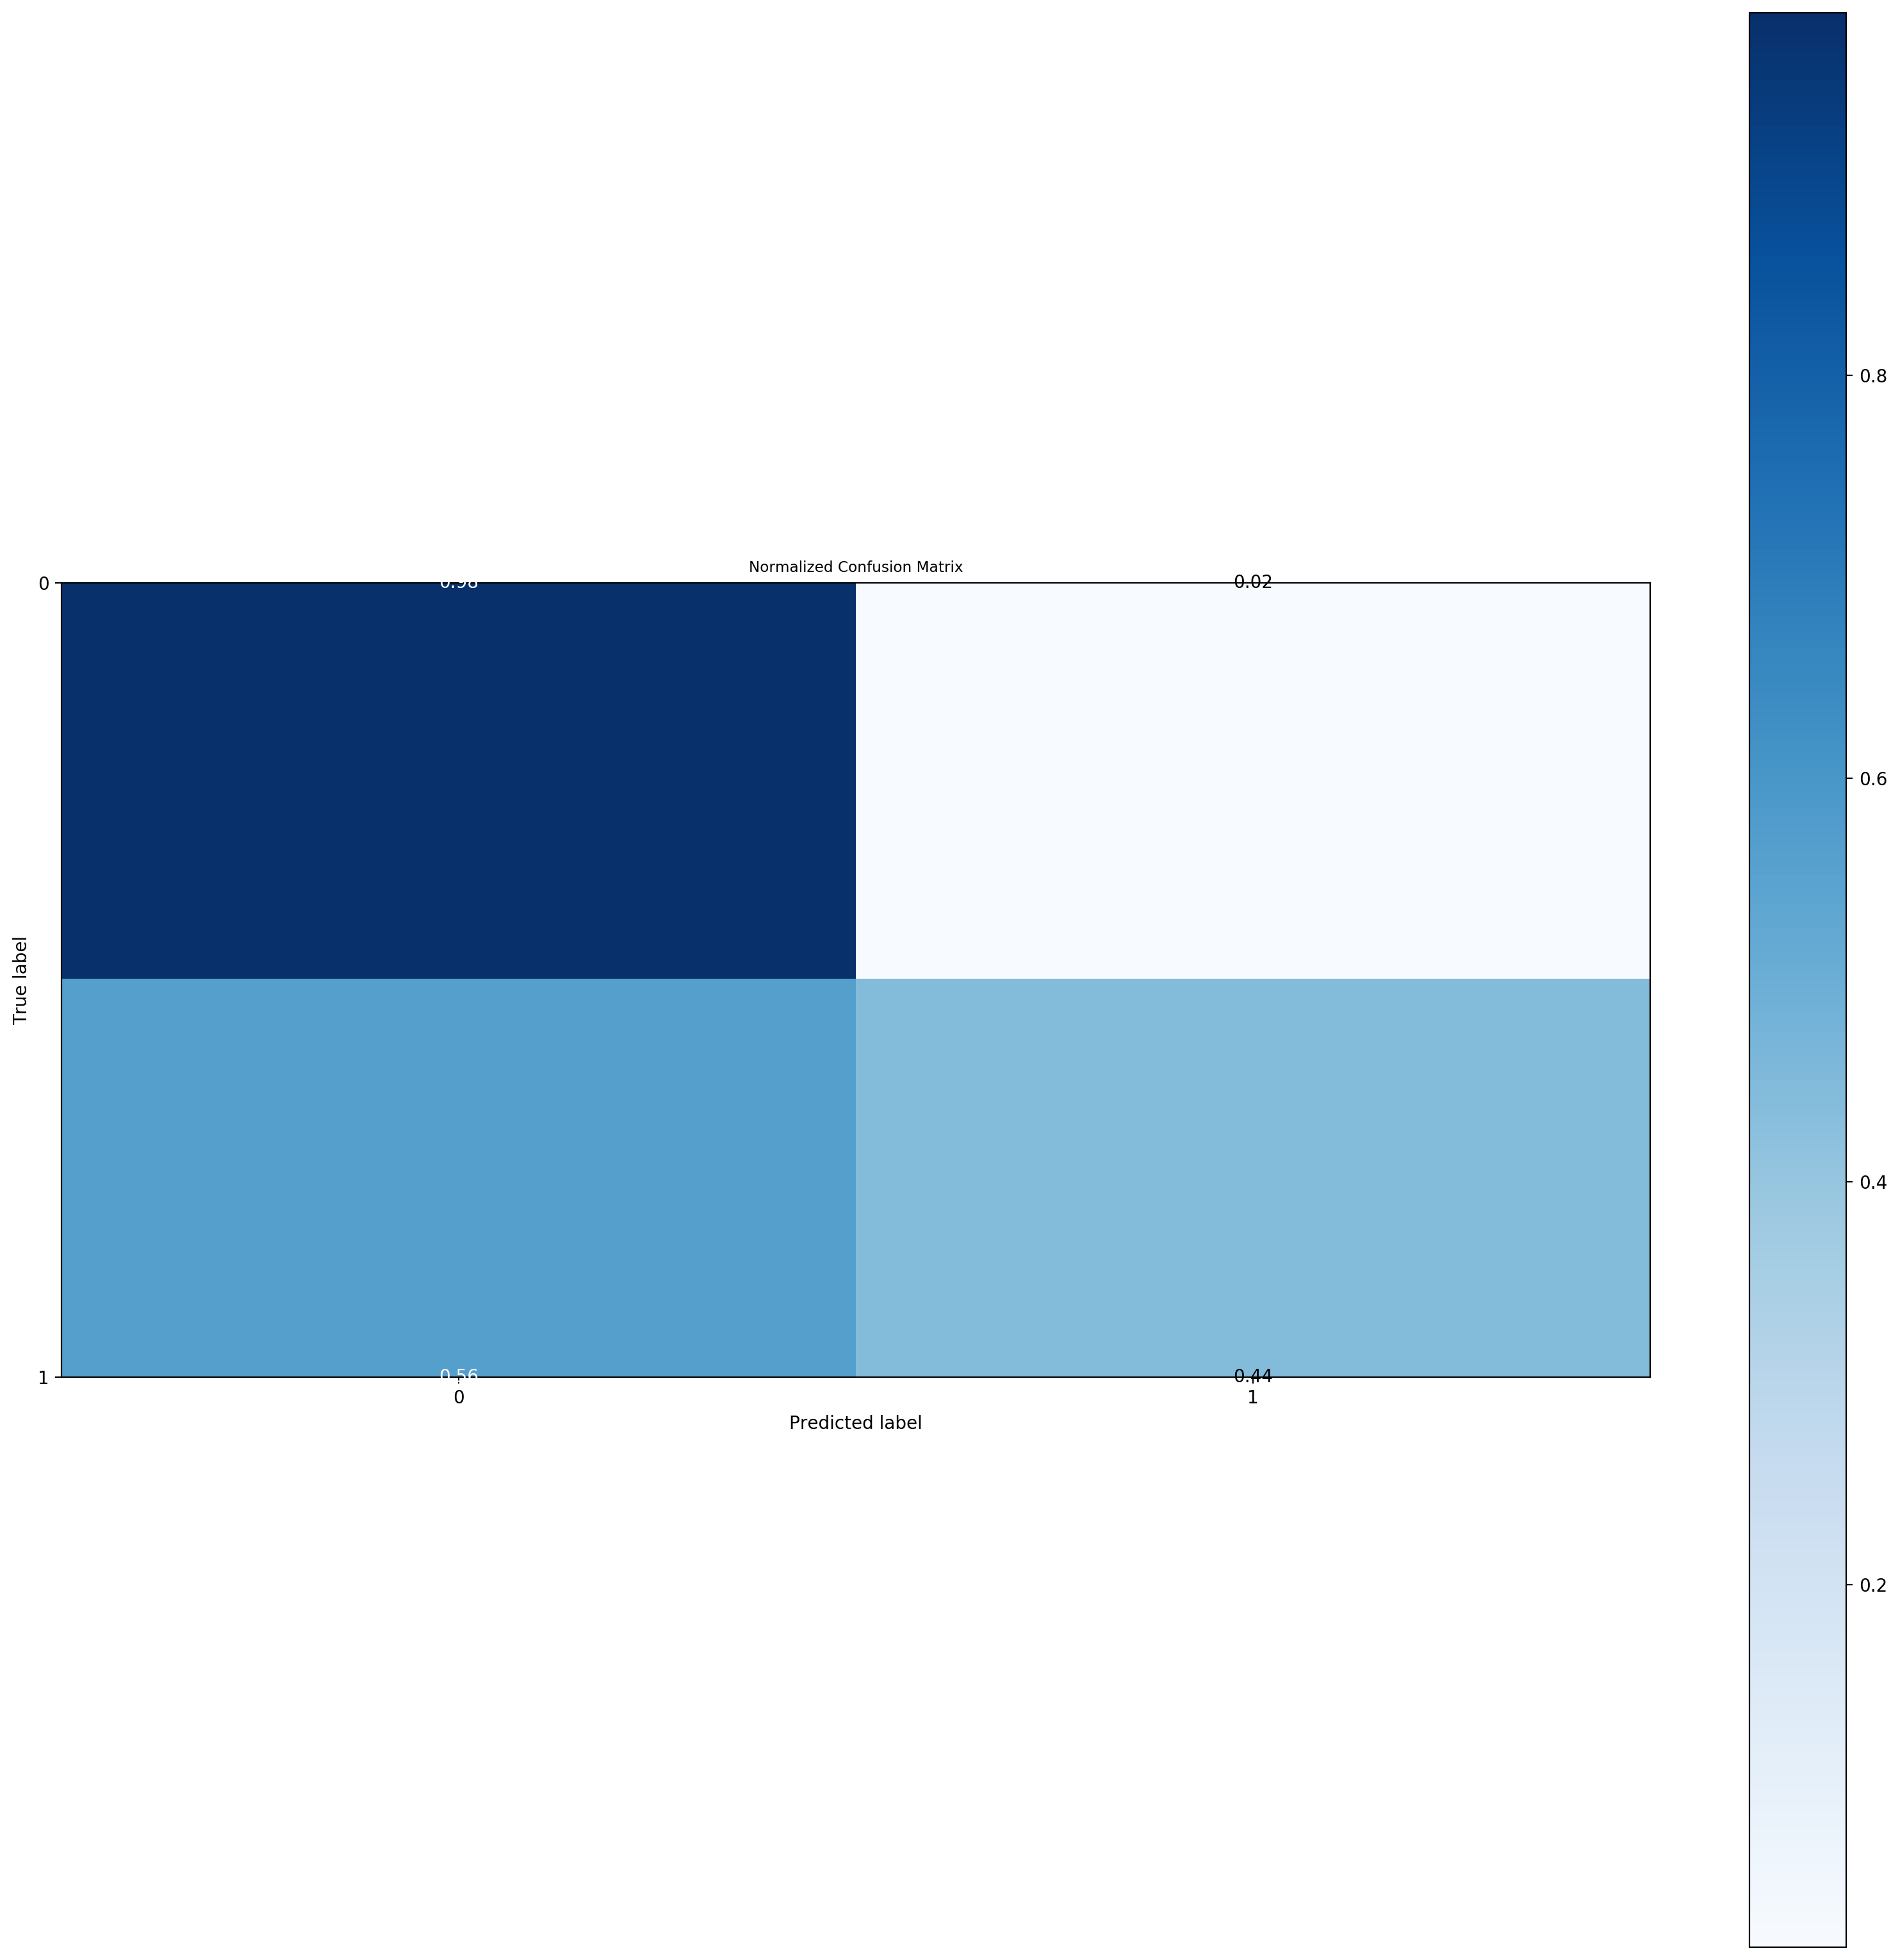

In [199]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(gs.predict(X_train), y_train, figsize=(20,20), normalize=True, title_fontsize='small')
plt.show()

## Using Scikit-plot

### ROC

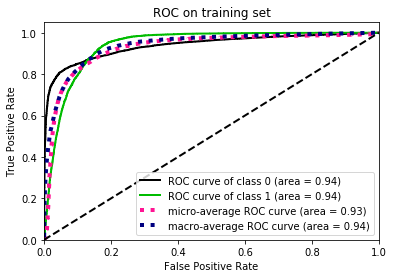

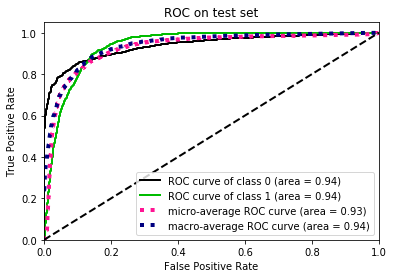

In [26]:
skplt.metrics.plot_roc(y_train, gs.predict_proba(X_train), title='ROC on training set')
skplt.metrics.plot_roc(y_test, gs.predict_proba(X_test), title='ROC on test set')

### KS statistic

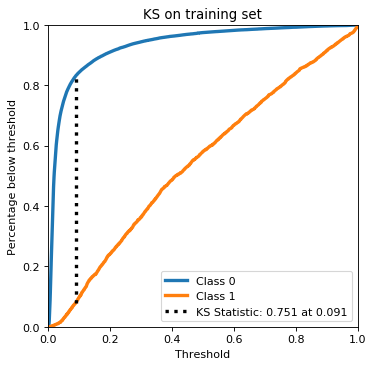

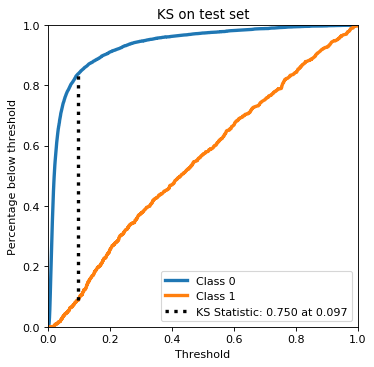

In [167]:
skplt.metrics.plot_ks_statistic(y_train, gs.predict_proba(X_train), title='KS on training set')
skplt.metrics.plot_ks_statistic(y_test, gs.predict_proba(X_test), title='KS on test set')

### Precision-Recall Curve

In [ ]:
skplt.metrics.plot_precision_recall(y_train, gs.predict_proba(X_train), title='Precision-recall on training set')
skplt.metrics.plot_precision_recall(y_test, gs.predict_proba(X_test), title='Precision-recall on test set')

In [187]:
from sklearn.metrics import classification_report
print(classification_report(y_train, gs.predict(X_train)))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     29245
           1       0.67      0.42      0.52      3705

    accuracy                           0.91     32950
   macro avg       0.80      0.70      0.73     32950
weighted avg       0.90      0.91      0.90     32950



In [186]:
from sklearn.metrics import classification_report
print(classification_report(y_test, gs.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7303
           1       0.67      0.43      0.52       935

    accuracy                           0.91      8238
   macro avg       0.80      0.70      0.74      8238
weighted avg       0.90      0.91      0.90      8238



### Calibration curve

In [ ]:
skplt.metrics.plot_calibration_curve(y_train, [gs.predict_proba(X_train)],clf_names=['Logistic Regression'],
                                     title='Probability calibration on training set')
skplt.metrics.plot_calibration_curve(y_test, [gs.predict_proba(X_test)], clf_names=['Logistic Regression'],
                                     title='Probability calibration on test set')

### Cumulative gain

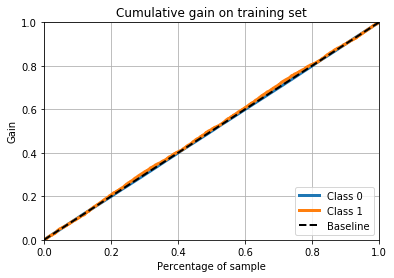

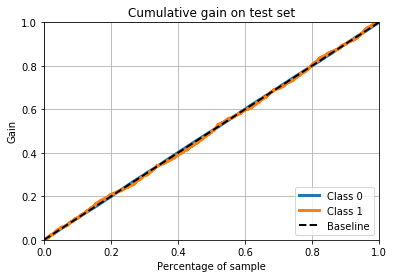

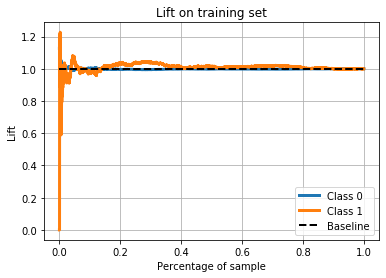

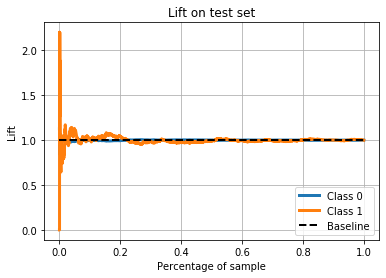

In [27]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy='uniform')
dummy_clf.fit(X_train, y_train)
skplt.metrics.plot_cumulative_gain(y_train, dummy_clf.predict_proba(X_train), title='Cumulative gain on training set')
skplt.metrics.plot_cumulative_gain(y_test, dummy_clf.predict_proba(X_test), title='Cumulative gain on test set')

skplt.metrics.plot_lift_curve(y_train, dummy_clf.predict_proba(X_train), title='Lift on training set')
skplt.metrics.plot_lift_curve(y_test, dummy_clf.predict_proba(X_test), title='Lift on test set')



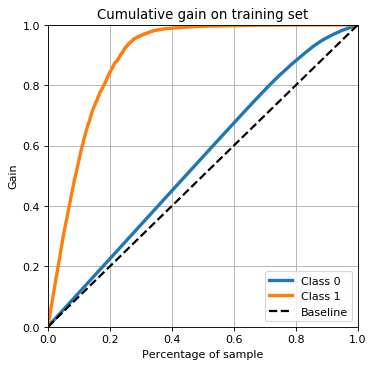

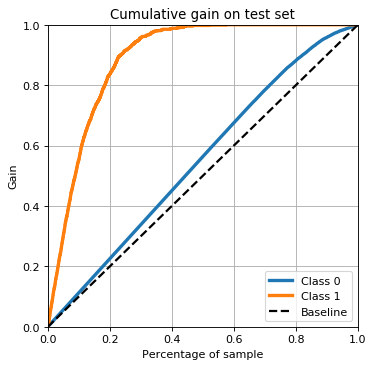

In [69]:
skplt.metrics.plot_cumulative_gain(y_train, gs.predict_proba(X_train), title='Cumulative gain on training set')
skplt.metrics.plot_cumulative_gain(y_test, gs.predict_proba(X_test), title='Cumulative gain on test set')

### Lift curve

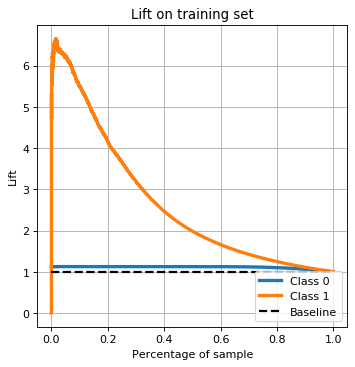

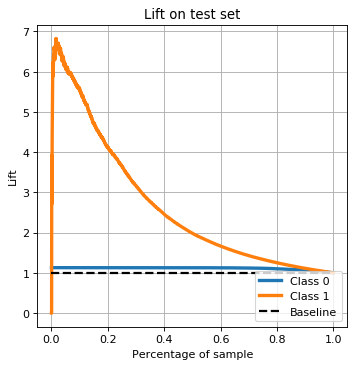

In [168]:
skplt.metrics.plot_lift_curve(y_train, gs.predict_proba(X_train), title='Lift on training set')
skplt.metrics.plot_lift_curve(y_test, gs.predict_proba(X_test), title='Lift on test set')

### Plot all statistics

In [ ]:
skplt.metrics.plot_calibration_curve(y_train, [gs.predict_proba(X_train)],clf_names=['Logistic Regression'],
                                     title='Probability calibration on training set')

In [202]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams["figure.figsize"] = (5,5)
plt.grid = True

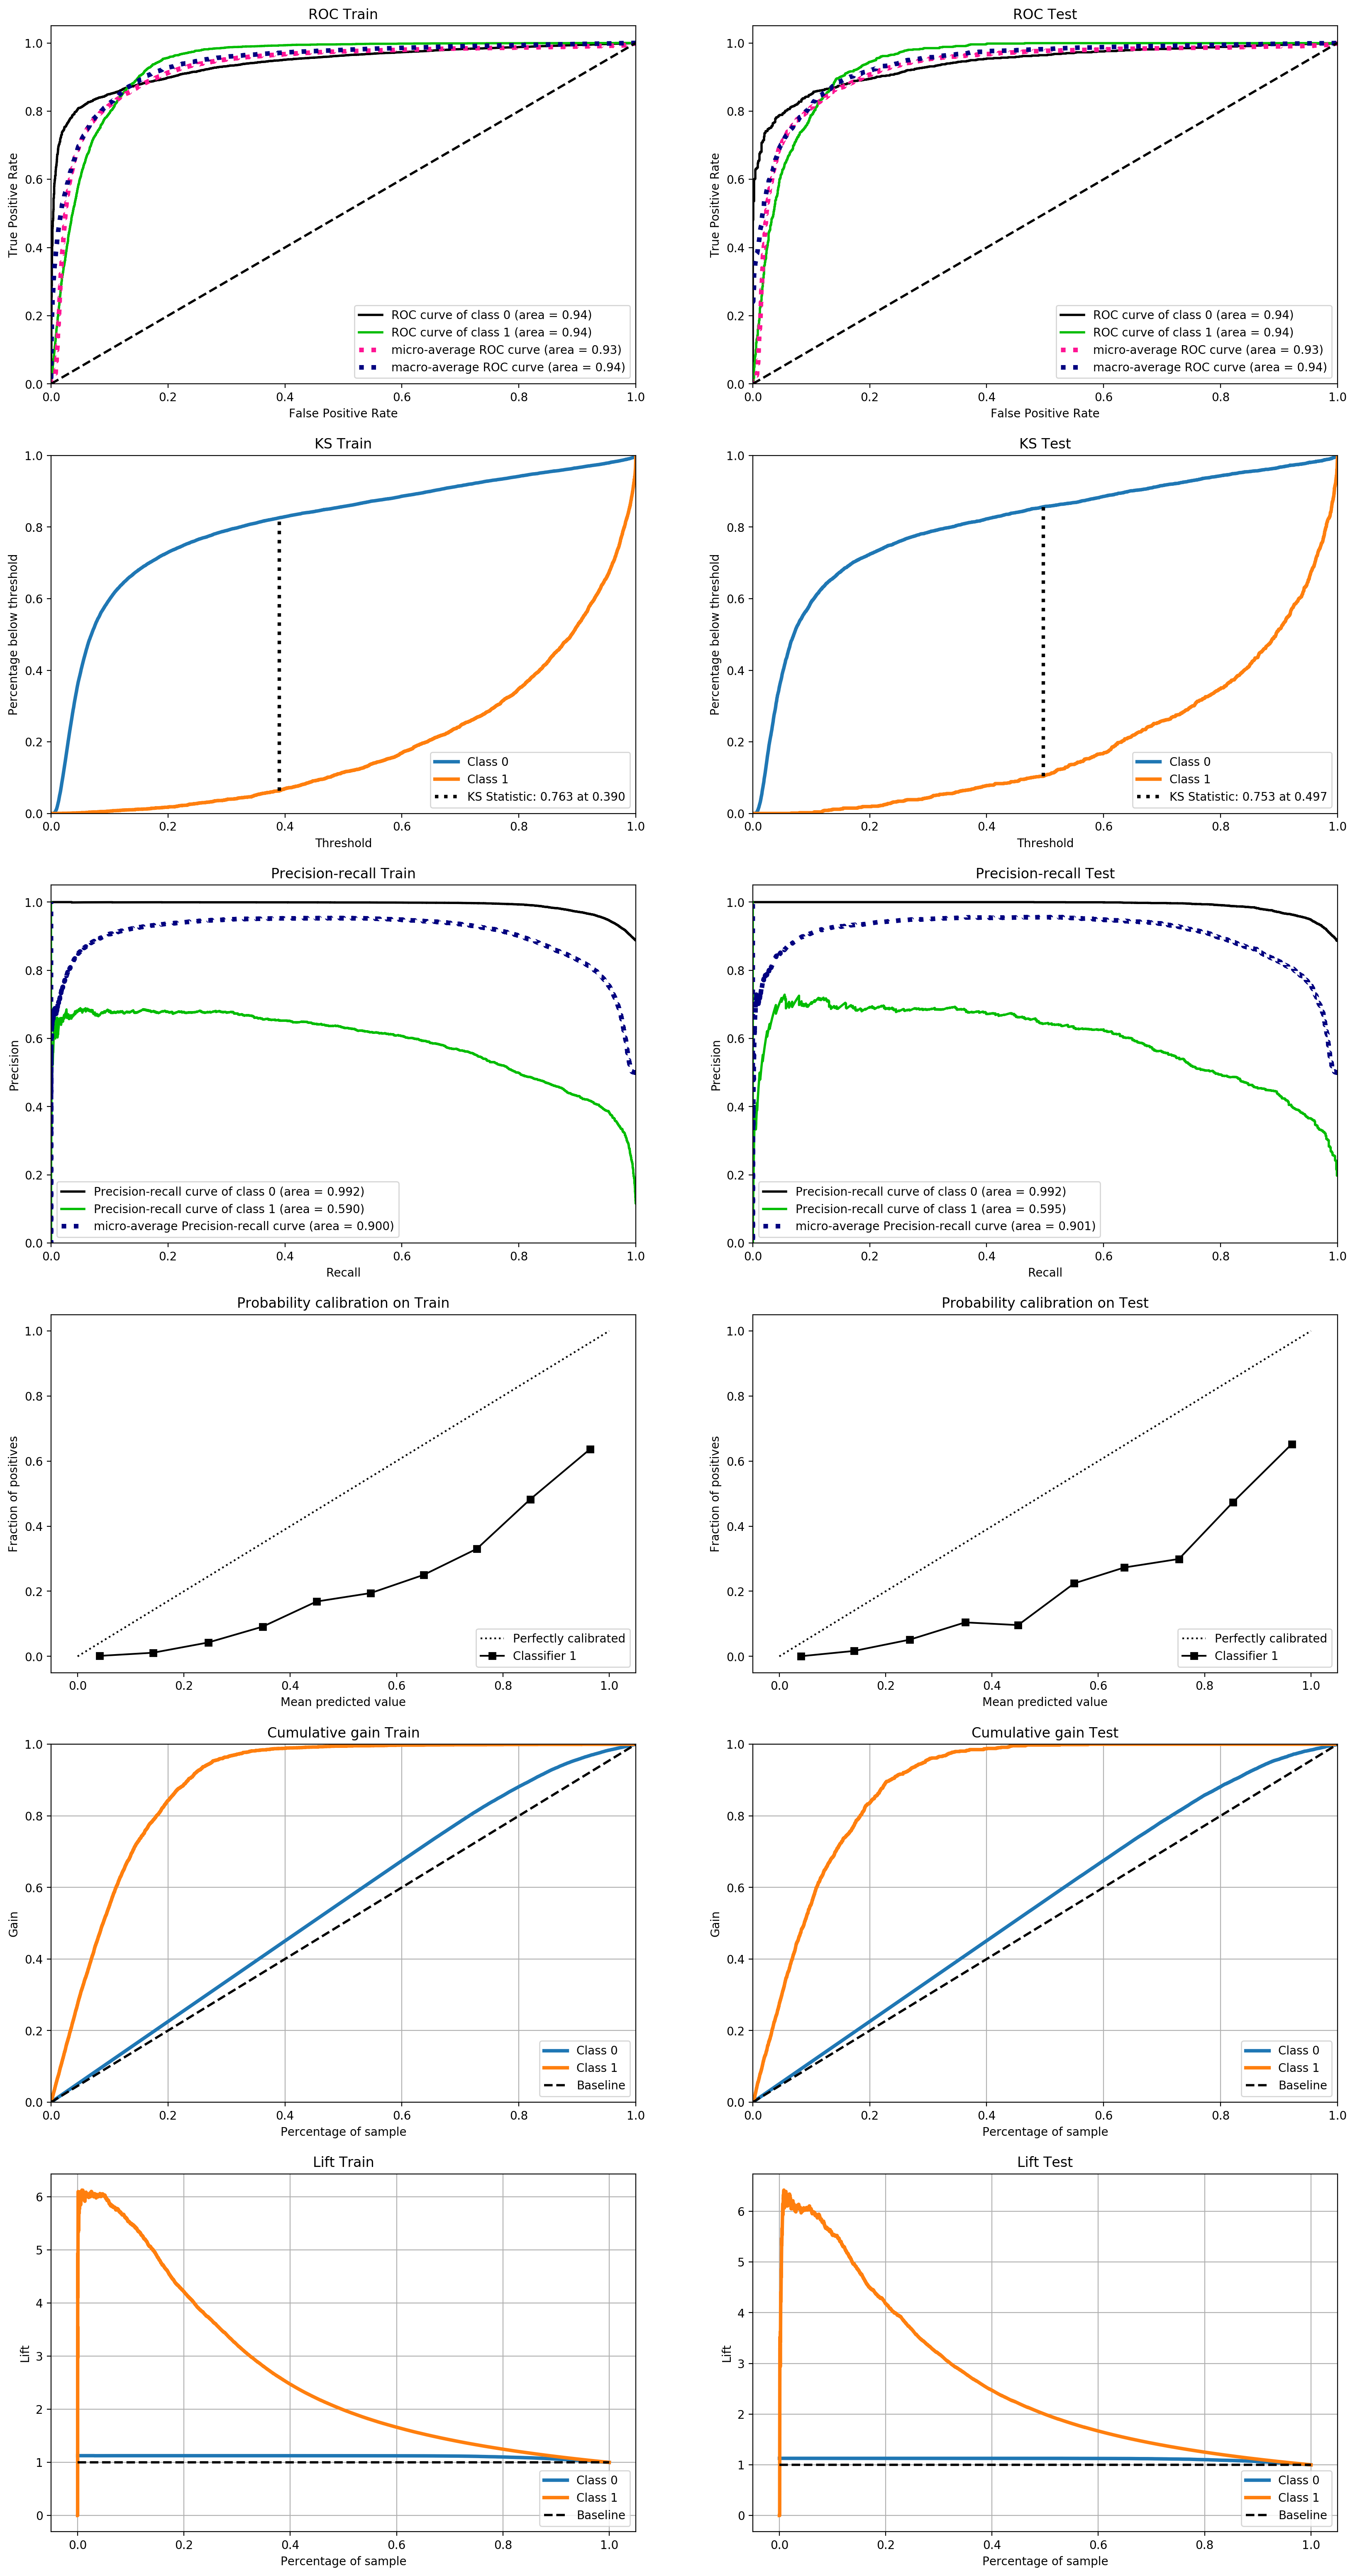

In [208]:
def plots_skplt_classification(*args):
    
    n_args = len(args)
    fig, axs = plt.subplots(nrows = 6, ncols=len(args), figsize=(n_args * 10,40))
#     fig = plt.figure(figsize=(n_args * 20,20))
    
    for i in range(n_args):
        skplt.metrics.plot_roc(args[i][1], gs.predict_proba(args[i][0]), title=f'ROC {args[i][2]}', ax=axs[0, i])
        skplt.metrics.plot_ks_statistic(args[i][1], gs.predict_proba(args[i][0]), title=f'KS {args[i][2]}', ax=axs[1, i])
        skplt.metrics.plot_precision_recall(args[i][1], gs.predict_proba(args[i][0]),
                                            title=f'Precision-recall {args[i][2]}', ax=axs[2, i])
        skplt.metrics.plot_calibration_curve(args[i][1], [gs.predict_proba(args[i][0])],
                                             title=f'Probability calibration on {args[i][2]}', ax=axs[3, i])
        skplt.metrics.plot_cumulative_gain(args[i][1], gs.predict_proba(args[i][0]), title=f'Cumulative gain {args[i][2]}'
                                           , ax=axs[4, i])
        skplt.metrics.plot_lift_curve(args[i][1], gs.predict_proba(args[i][0]), title=f'Lift {args[i][2]}', ax=axs[5, i])
    
    
#         plt.grid()
        
#         plt.tight_layout()    
    plt.show()
    
    return

plots_skplt_classification((X_train, y_train, 'Train'), (X_test, y_test, 'Test'))
# plots_skplt_classification(X_train=X_train, y_train = y_train, X_test = X_test, y_test = y_test, model=gs)

## Bin score

In [220]:
from sklearn.preprocessing import KBinsDiscretizer
binner = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
binner.fit(gs.predict_proba(X_train)[:,1].reshape(-1,1))
# plt.hist(binner.fit_transform(gs.predict_proba(X_train)[:,1].reshape(-1,1)))

KBinsDiscretizer(encode='ordinal', n_bins=10, strategy='quantile')

In [221]:
# Treino
a = pd.DataFrame()
a['score'] = gs.predict_proba(X_train)[:,1]
a['bin'] = 9 - binner.transform(a['score'].values.reshape(-1,1))
a['target'] = y_train.values
a.groupby('bin')['target'].agg(['mean', 'size', 'sum']).reset_index()

,bin,mean,size,sum
0,0.0,0.618209,3295,2037.0
1,1.0,0.329287,3295,1085.0
2,2.0,0.136267,3295,449.0
3,3.0,0.027921,3295,92.0
4,4.0,0.006677,3295,22.0
5,5.0,0.003336,3297,11.0
6,6.0,0.001215,3293,4.0
7,7.0,0.000607,3295,2.0
8,8.0,0.000303,3295,1.0
9,9.0,0.000607,3295,2.0


In [222]:
# Validação
a = pd.DataFrame()
a['score'] = gs.predict_proba(X_test)[:,1]
a['bin'] = 9 - binner.transform(a['score'].values.reshape(-1,1))
a['target'] = y_test.values
a.groupby('bin')['target'].agg(['mean', 'size', 'sum']).reset_index()

,bin,mean,size,sum
0,0.0,0.628129,839,527.0
1,1.0,0.315337,815,257.0
2,2.0,0.133960,851,114.0
3,3.0,0.031063,837,26.0
4,4.0,0.010601,849,9.0
5,5.0,0.002488,804,2.0
6,6.0,0.000000,798,0.0
7,7.0,0.000000,808,0.0
8,8.0,0.000000,807,0.0
9,9.0,0.000000,830,0.0


(array([17662.,  3784.,  1830.,  1240.,   997.,  1044.,  1126.,  1156.,
         1344.,  2767.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

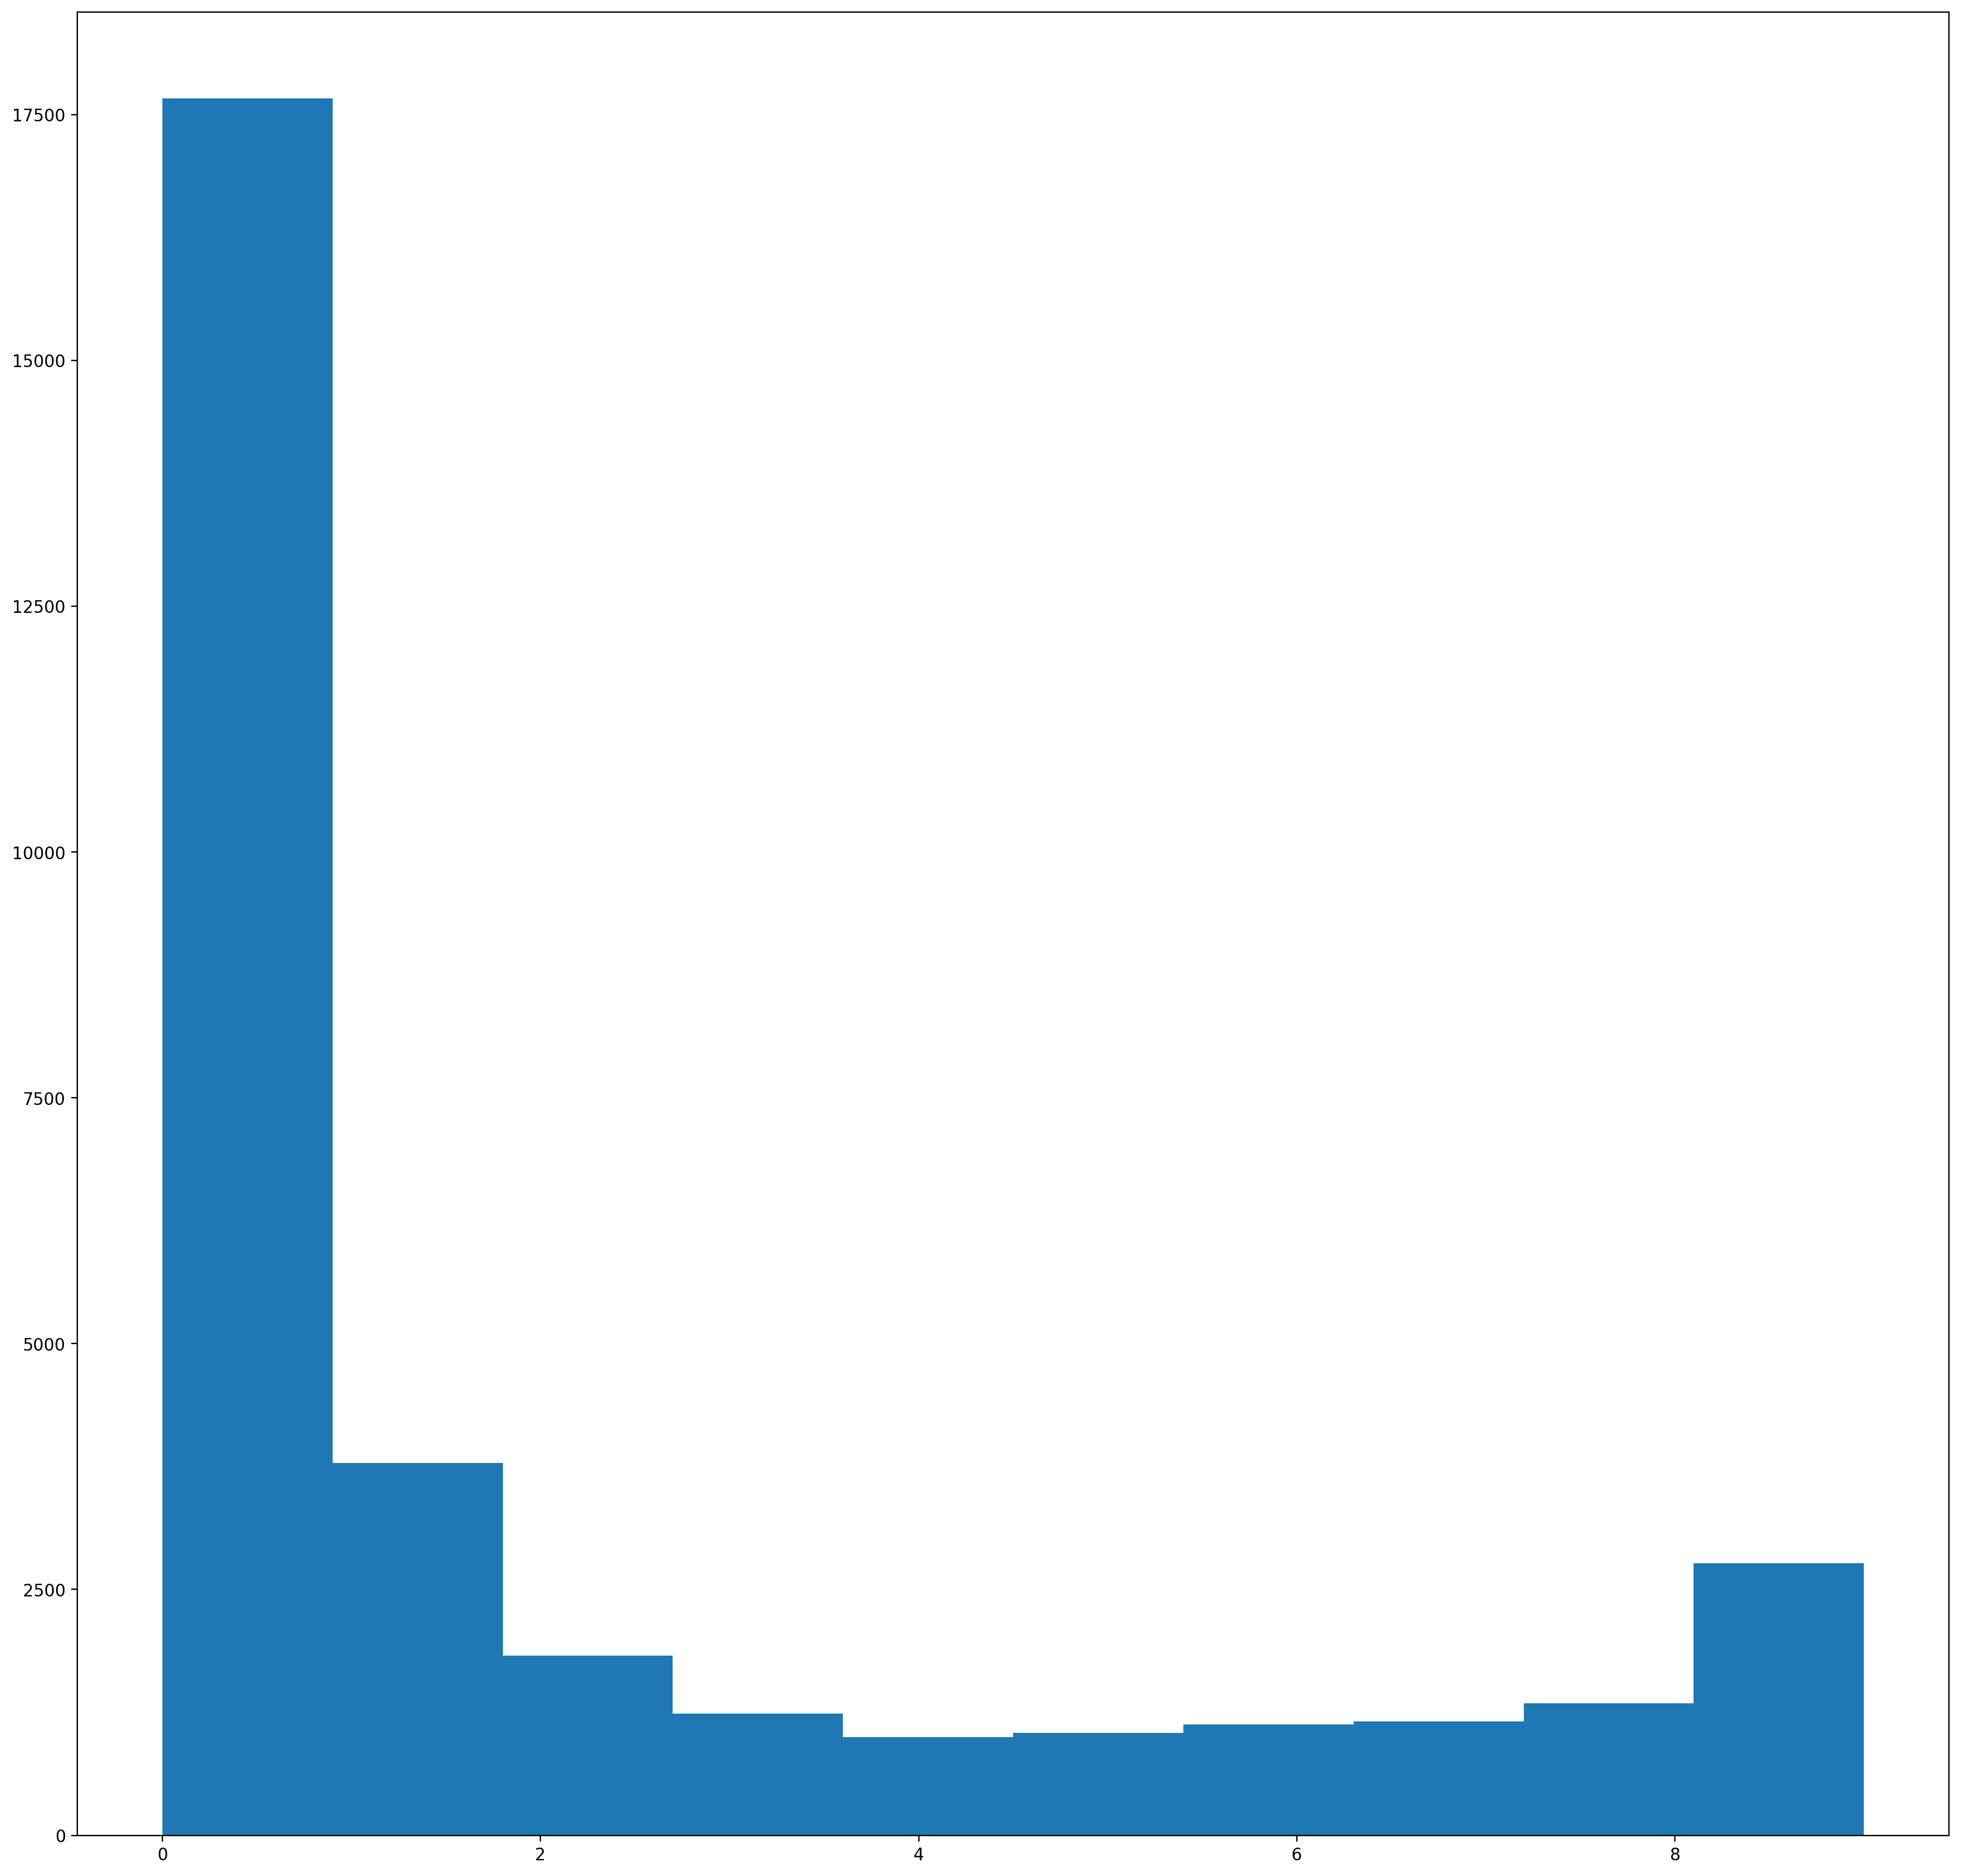

In [201]:
binner = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
plt.hist(binner.fit_transform(gs.predict_proba(X_train)[:,1].reshape(-1,1)))

(array([12805.,  5955.,  2847.,  1866.,  1447.,  1317.,  1426.,  1397.,
         1524.,  2366.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

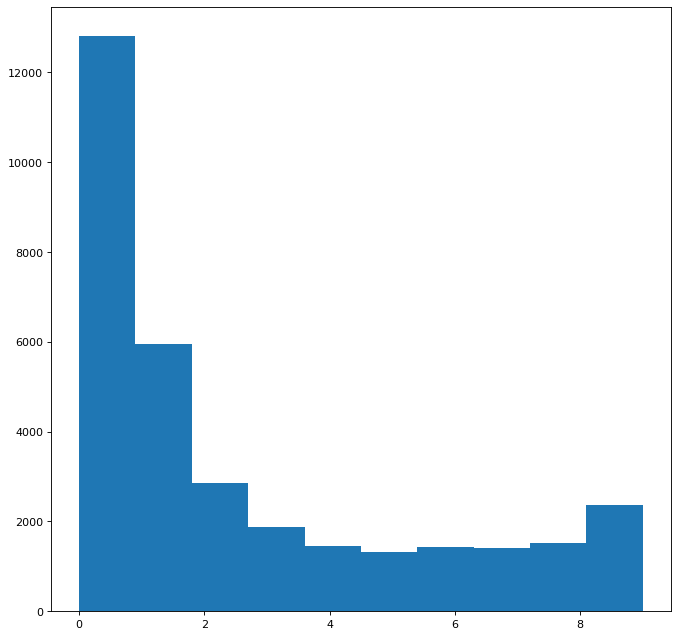

In [65]:
binner = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans')
plt.hist(binner.fit_transform(gs.predict_proba(X_train)[:,1].reshape(-1,1)))

# LGBM

## Crossval

In [305]:
train_data = lgb.Dataset(data=X_train, label=y_train, feature_name=X_train.columns.to_list(), categorical_feature='auto')

params = {
    'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': 1.0,
    'importance_type': 'split',
    'learning_rate': 0.1,
    'max_depth': -1,
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'min_split_gain': 0.0,
#     'n_estimators': 1000,
    'n_jobs': -1,
    'num_leaves': 31,
    'objective': 'binary',
    'random_state': None,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
     'scale_pos_weight':2,
    'subsample': 1.0,
    'subsample_for_bin': 200000,
    'subsample_freq': 0
} 

bst = lgb.cv(train_set=train_data 
             ,early_stopping_rounds=50
             ,num_boost_round=1000
             ,folds=kf
            ,params=params
            ,verbose_eval=1
#             ,metrics='auc'
            ,feval=ks_lgbm)

[1]	cv_agg's binary_logloss: 0.302452 + 0.000909744	cv_agg's KS: 0.768995 + 0.00982891
[2]	cv_agg's binary_logloss: 0.276062 + 0.00132624	cv_agg's KS: 0.776684 + 0.00947948
[3]	cv_agg's binary_logloss: 0.257984 + 0.00159208	cv_agg's KS: 0.780981 + 0.00964038
[4]	cv_agg's binary_logloss: 0.244656 + 0.0018609	cv_agg's KS: 0.781044 + 0.00941367
[5]	cv_agg's binary_logloss: 0.234252 + 0.00194422	cv_agg's KS: 0.783169 + 0.0125201
[6]	cv_agg's binary_logloss: 0.225852 + 0.00226797	cv_agg's KS: 0.780926 + 0.0118469
[7]	cv_agg's binary_logloss: 0.219099 + 0.00239754	cv_agg's KS: 0.782174 + 0.0114332
[8]	cv_agg's binary_logloss: 0.213474 + 0.0025433	cv_agg's KS: 0.781679 + 0.0106486
[9]	cv_agg's binary_logloss: 0.208685 + 0.00266826	cv_agg's KS: 0.783417 + 0.0110747
[10]	cv_agg's binary_logloss: 0.204916 + 0.00287324	cv_agg's KS: 0.785206 + 0.0110875
[11]	cv_agg's binary_logloss: 0.201571 + 0.00300533	cv_agg's KS: 0.785973 + 0.0102145
[12]	cv_agg's binary_logloss: 0.198844 + 0.00316769	cv_agg's

[96]	cv_agg's binary_logloss: 0.181064 + 0.00501612	cv_agg's KS: 0.795577 + 0.00850791
[97]	cv_agg's binary_logloss: 0.181042 + 0.00508862	cv_agg's KS: 0.79566 + 0.0087757
[98]	cv_agg's binary_logloss: 0.181008 + 0.00510796	cv_agg's KS: 0.795863 + 0.00888725
[99]	cv_agg's binary_logloss: 0.181022 + 0.00512442	cv_agg's KS: 0.796562 + 0.00892915
[100]	cv_agg's binary_logloss: 0.18108 + 0.00514072	cv_agg's KS: 0.796112 + 0.00877734
[101]	cv_agg's binary_logloss: 0.181092 + 0.00517405	cv_agg's KS: 0.796235 + 0.00846419
[102]	cv_agg's binary_logloss: 0.181102 + 0.00518744	cv_agg's KS: 0.796413 + 0.0085237
[103]	cv_agg's binary_logloss: 0.181101 + 0.00516348	cv_agg's KS: 0.796413 + 0.00857737
[104]	cv_agg's binary_logloss: 0.181107 + 0.00513668	cv_agg's KS: 0.796904 + 0.00791563
[105]	cv_agg's binary_logloss: 0.181101 + 0.0050976	cv_agg's KS: 0.796539 + 0.00763296
[106]	cv_agg's binary_logloss: 0.181084 + 0.00515043	cv_agg's KS: 0.796742 + 0.00812143
[107]	cv_agg's binary_logloss: 0.181106 +

In [299]:
# self-defined eval metric
# f(preds: array, train_data: Dataset) -> name: string, eval_result: float, is_higher_better: bool
def ks_lgbm(preds, train_data):
    labels = train_data.get_label()
    return 'KS', ks_2samp(preds[labels==1], preds[labels!=1]).statistic, True

## Como tunar lgbm

In [301]:
https://github.com/microsoft/LightGBM/issues/695
https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
https://github.com/Microsoft/LightGBM/issues/1244
https://github.com/microsoft/LightGBM/blob/master/docs/Parameters.rst

SyntaxError: invalid syntax (<ipython-input-301-dead596a74cc>, line 1)

In [ ]:
pos_bagging_fraction
bagging_freq
scale_pos_weight